# Лабораторная работа №5

Асланов А.Б., ИУ9-31М

Программируем нейронную сеть LeNet5 на PyTorch.    
В этой сети:
- 5 полносвязных слоёв;
- 2 свёртки;
- 3 полносвязных слоя.    
В целом архитектура немного отличается от оригинальной.

In [1]:
import torch
import random
import numpy as np
import torchvision.datasets
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

0it [00:00, ?it/s]

 99%|█████████▉| 9822208/9912422 [00:13<00:00, 989889.55it/s] 

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



0it [00:00, ?it/s]


 57%|█████▋    | 16384/28881 [00:00<00:00, 98918.08it/s]
32768it [00:00, 62793.64it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



 99%|█████████▉| 1638400/1648877 [00:04<00:00, 754135.72it/s]
1654784it [00:04, 384557.11it/s]                             
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]
8192it [00:00, 18164.72it/s]            

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


9920512it [00:30, 989889.55it/s]                             

In [3]:
X_train = MNIST_train.data   # data = бывш. train_data
y_train = MNIST_train.targets   # targets = бывш. train_labels
X_test = MNIST_test.data
y_test = MNIST_test.targets

In [4]:
# Количество картинок на обучение и тест
len(y_train), len(y_test)

(60000, 10000)

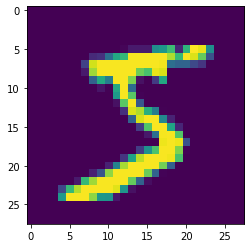

tensor(5)


In [5]:

plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [6]:
# В отличие от полносвязной сети, которая видела картинку как один длинный вектор,
# мы хотим в сверточную сеть передавать картинку как трехмерный тензор 
# Мы смотрим картинку в grayscale --> 1 канал
# То есть тут мы делаем reshape тензора в 60000 картинок с одним каналом (глубина) и размерностью каждой 28х28.
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [7]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [8]:
# На вход принимается 1 канал (так как grayscale), на выходе 6 каналов
# Хотим, чтобы размерность была 28х28 --> ставим padding на 2 пикселя, 
# чтобы итоговая размерность тензора сохранилась.
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        # первый свёрточный слой, если б было RGB --> Conv3D
        # размер ядра свёртки = 5
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        # Функция активации - гиперболический тангенс
        self.act1  = torch.nn.Tanh()
        # AveragePooling для сжатия - дань традициям, хотя обычно в 2к19 используется maxpooling
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Тут представим, что мы уже растянули вектор в одномерный (см. коммент ###!)
        # Полносвязный слой. Если бы он был растянут в одномерный, то изображение бы подавалось 
        # размерностью 5х5 и глубиной 16 (5*5*16=400 - размер вектора)
        # На выходе хотим вектора размера 120
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        # Из 84 нейронов делаем 10 с ответами (потому что чисел от 0 до 9)
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        """
        Повторяем логику метода __init__, но применяем слои к входному тензору X.
        X - batch из картинок
        """
        
        # свёртка
        x = self.conv1(x)
        # применение функции активации
        x = self.act1(x)
        # pooling
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        ###! Здесь мы растягиваем тензор, чтобы преобразовать его к одномерному формату.
        # x.size(0) - это размер батча, 
        # x.size(1) = 5
        # x.size(2) = 5
        # x.size(3) = 16
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

# инициализируем сеть
lenet5 = LeNet5()

In [9]:
# проверка на наличие GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [10]:
# шаг градиентного спуска = 0.001
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [11]:
epochs_num = 20 # потому что у меня CPU, а вообще надо брать 10000 или около того того же порядка
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs_num):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()   # внутри каждого батча обнуляем градиенты
        
        # выбираем, какие картинки пойдут в текущий батч
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)   # перенос текущего батча на GPU
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch)  # прогоняем батч через сеть (=прямой проход = forward pass)
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()   # считаем градиенты
        
        # делаем шаг градиентного спуска
        optimizer.step()
    
    # считаем качество на отложенной выборке
    test_preds = lenet5.forward(X_test)
    # Нам нужны только численные представления функции потерь, то есть
    # нам не нужно хранить весь граф вычислений производной для обсчёта градиентов, 
    # поэтому здесь приводим всё к одному числу для функции потреь (скаляру) и чтоб это всё
    # не занимало память на GPU --> отправляем всё в CPU.
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    # СЧИТАЕМ КАЧЕСТВО
    # Берем нейрон, у которого выход наибольший. 
    # Чтобы понять, у какого по счёту нейрона выход наибольший, берём argmax
    # Сравниваем предсказываемую нейросетью цифру с таргетной цифрой, которая должна получиться (groundtruth)
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)

tensor(0.9749)
tensor(0.9830)
tensor(0.9855)
tensor(0.9883)
tensor(0.9902)
tensor(0.9886)
tensor(0.9894)
tensor(0.9882)
tensor(0.9887)
tensor(0.9885)
tensor(0.9894)
tensor(0.9901)
tensor(0.9882)
tensor(0.9900)
tensor(0.9901)
tensor(0.9899)
tensor(0.9894)
tensor(0.9905)
tensor(0.9875)
tensor(0.9897)


In [12]:
lenet5.forward(X_test)

tensor([[-2.9423,  0.0717,  0.1841,  ..., 16.5307, -4.7692,  3.3224],
        [-0.7647,  0.6360, 16.7354,  ..., -2.8282,  2.0145, -4.0262],
        [-3.8264, 17.6337, -1.8363,  ...,  2.7907,  1.0463, -4.6785],
        ...,
        [-5.6251, -2.8034, -5.0496,  ...,  0.6560,  1.4267,  3.8189],
        [-2.1859, -3.0887, -5.0559,  ..., -4.7734,  2.6247, -4.9940],
        [ 2.4288, -3.5114,  0.8495,  ..., -9.3530, -2.1698, -4.7903]],
       grad_fn=<AddmmBackward>)

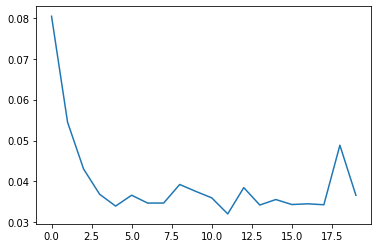

In [13]:
plt.plot(test_loss_history);

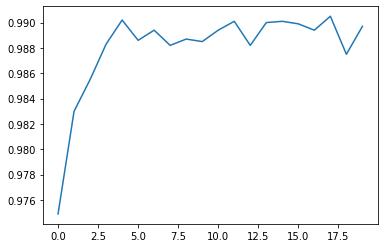

In [14]:
plt.plot(test_accuracy_history);